 # MP1 - ECE 498:  Data Science & Analytics
 
 
 # Group members (NetIDs): 
    
 ##   Akhilesh Somani (somani4)
 ##   Gowtham Kuntumalla (gowtham4)
 ##   Manan Mehta (mananm2)

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np  
from datetime import datetime
from scipy import stats as st
import math
from sklearn import datasets
from sklearn.model_selection import train_test_split

# to handle file imports for different OS
import os
from pathlib import Path 

# ----------------------------- Task 0 -----------------------------

In [2]:
folder = Path(os.getcwd())
file1 = folder / 'mp1_av_disengagements.csv'
file2 = folder / 'mp1_av_totalmiles.csv'
dseng_df = pd.read_csv(file1)
summary_month_df = pd.read_csv(file2)

# make number of months unique by combining different cars
summary_month_df = summary_month_df.groupby('Month',sort=False, as_index = False).sum()


In [3]:
dseng_df.head()

,Month,Car,Location,Weather,TypeOfTrigger,ReactionTime,Cause
0,14-Sep,WDD2221851A001072,urban-street,cloudy,automatic,0.58,Incorrect Traffic Light Detection
1,14-Sep,WDD2221851A001072,urban-street,cloudy,automatic,0.66,Adverse road surface conditions
2,14-Sep,WDD2221851A001072,urban-street,cloudy,automatic,1.93,Position Estimation Failure
3,14-Sep,WDD2221851A001072,urban-street,cloudy,automatic,0.65,Emergency Vehicle
4,14-Sep,WDD2221851A001072,urban-street,cloudy,automatic,0.64,Adverse road surface conditions


In [4]:
summary_month_df.head()

,Month,miles driven in autonomous mode,total number of disengagements,number of automatic disengagements,number of manual disengagements
0,14-Sep,4207,44,24,20
1,14-Oct,61881,244,111,133
2,14-Nov,58824,189,85,104
3,14-Dec,9413,36,15,21
4,15-Jan,18192,48,18,30


### 0.2 (a) Total number of AV disengagements: 1024

In [5]:
dseng_df.count()

Month            1024
Car              1024
Location         1024
Weather          1024
TypeOfTrigger    1024
ReactionTime      492
Cause            1024
dtype: int64

### 0.2 (b) Number of unique months that have recorded AV disengagements: 15

In [6]:
dseng_df['Month_actual'] = dseng_df['Month'].apply(lambda x:x.split("-")[1])

In [7]:
dseng_df['Month'].nunique()

15

### 0.2 (c) List of unique locations of AV disengagements: 2

In [8]:
dseng_df['Location'].nunique()

2

### 0.2 (d) Number of unique causes for AV disengagements: 10 

In [9]:
dseng_df['Cause'].nunique()

10

### 0.2 (e) ReactionTime has 532 missing values because Manual Trigger

In [10]:
dseng_df.isnull().sum()

Month              0
Car                0
Location           0
Weather            0
TypeOfTrigger      0
ReactionTime     532
Cause              0
Month_actual       0
dtype: int64

### 0.3 The top two leading causes of disengagement: Recklessly behaving agent and Unwanted Driver Discomfort

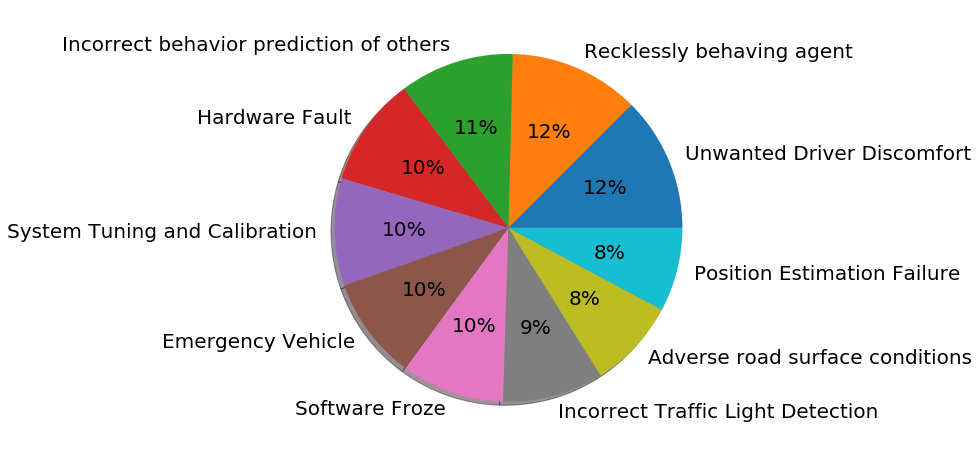

In [11]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
import matplotlib as mpl
mpl.rcParams['font.size'] = 20.0

causes = dseng_df['Cause'].value_counts()
causes = causes[causes>10]
patches, texts, _ = plt.pie(causes, 
        # grab labels from frame keys
        labels=causes.keys(),
        # some formatting
        autopct='%.0f%%', shadow=True)
#plt.legend(patches, labels=causes.keys(), bbox_to_anchor=(0.85,1.025),loc="upper left")
#plt.axis('equal')
plt.show()

### 0.4 AVs are indeed maturing over time

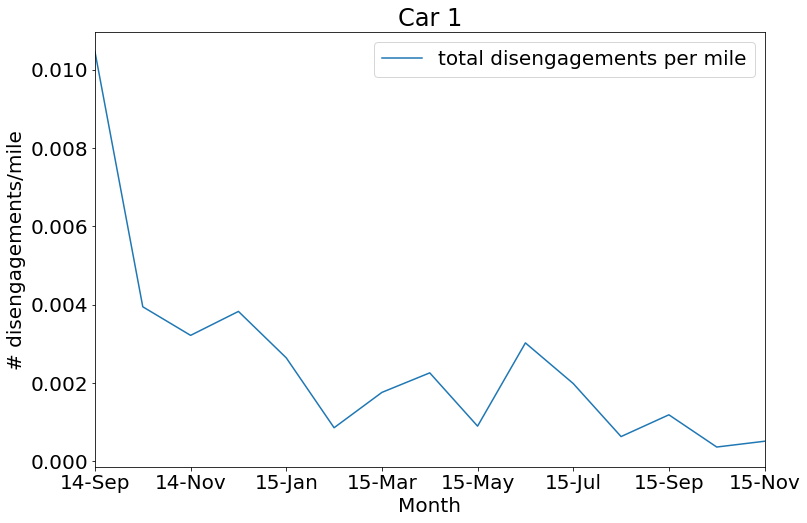

In [12]:
#disengagement/mile
summary_month_df['total disengagements per mile'] = summary_month_df['total number of disengagements']\
/summary_month_df['miles driven in autonomous mode']

#print(summary_month_df['total disengagement per mile'])

summary_month_df.iloc[:15,:].plot(x = 'Month',y = 'total disengagements per mile')
plt.xlabel('Month')
plt.ylabel('# disengagements/mile')
plt.title('Car 1')
plt.show()

# ----------------------------- Task 1 -----------------------------

### 1.1 Various distributions:

#### a. Gaussian distribution : 
Also called normal distribution, samples drawn from it follow the general distribution which is given by 
$$ {\ f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}} $$

Samples drawn are likely to be close to the mean. and those far away are less likely.

#### b. Exponential distribution:
Here the general distribution is given by 
$$ f(x;\lambda) = \begin{cases}
\lambda e^{-\lambda x} & x \ge 0, \\
0 & x < 0.
\end{cases} $$

Samples drawn are likely to be close to Zero. Another key property is memorylessness. i.e. conditional probabability boils down to simple exponentials (only the time period matters not when it starts).

#### c. Weibull distribution:

Here the general distribution is given by 
$$ 
f(x;\lambda,k) =
\begin{cases}
\frac{k}{\lambda}\left(\frac{x}{\lambda}\right)^{k-1}e^{-(x/\lambda)^{k}} & x\geq0 ,\\
0 & x<0,
\end{cases} $$

It is a generalisation of standard exponential distribution (k = 1). 

If X = time-to-failure, then k < 1 indicates failure rate goes down as parts life increases, i.e. probaility that samples fail is very high when X is close to zero and then it decreases. Vice versa for k > 1.


### 1.2 Reaction times of drivers

In Weibull distribution fit, k value is 0.3


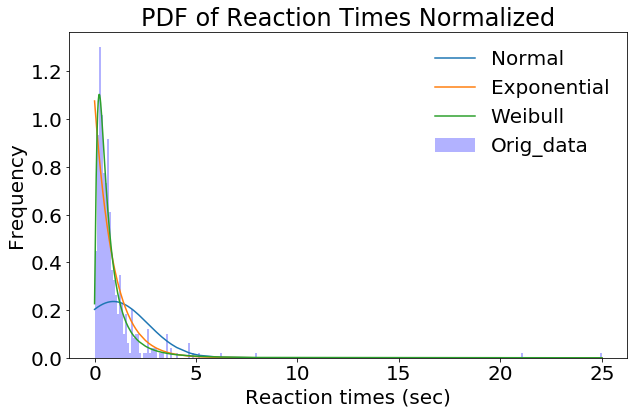

In [13]:

""" Actual PDF of reaction times using histograms """ 
plt.figure(figsize = (10,6))

reaction_t = dseng_df['ReactionTime'].dropna()
reaction_t.plot(kind='hist', bins  = 250, density = True, alpha=0.3, color = 'blue', label = 'Orig_data')

"""fitting scikit-learn stats model  """ 

x_data = sorted(reaction_t)
# normal
mean, var = st.norm.fit(x_data)
plt.plot(x_data, st.norm.pdf(x_data,mean,var), label = 'Normal')

# exponential
loc, scale = st.expon.fit(x_data)
plt.plot(x_data, st.expon.pdf(x_data,loc, scale), label = 'Exponential')

# weibull

args = st.exponweib.fit(x_data)
plt.plot(x_data, st.exponweib.pdf(x_data,*args), label = 'Weibull')
print("In Weibull distribution fit, k value is {0}".format(round(list(args)[1],2)))

plt.xlabel('Reaction times (sec)')
plt.ylabel('Frequency')
plt.title('PDF of Reaction Times Normalized')
plt.legend(frameon = False, loc = 'best')
plt.show()
 

### Observation: We see that the weibull distribution fits well. Parameter 'k' < 1 so the reaction times are largely populated in the beginning and go down with time.

### 1.3 Average Reaction Times

In [14]:
print("1.3(a) Average Reaction Time for entire data set = {0} sec \n\n".format(round(reaction_t.mean(),2)))

print("1.3(b) Average Reaction Time (sec) by \n")
print( round(dseng_df['ReactionTime'].groupby(dseng_df['Location']).mean(),2))


1.3(a) Average Reaction Time for entire data set = 0.93 sec 


1.3(b) Average Reaction Time (sec) by 

Location
highway         1.48
urban-street    0.93
Name: ReactionTime, dtype: float64


### 1.4 Hypothesis testing of reaction times 

Define 

H0 : AV_mean = 1.09 sec

H1 : AV_mean != 1.09 sec

Significance level  = 0.05

We will apply a two tail test asssuming H0 is true. We will test if 0.93 sec is in statistical limits of assumed population mean (= 1.09 sec)


In [15]:
std_AV_sample = reaction_t.std()
mean_AV_sample = reaction_t.mean()
mean_nonAV_pop = 1.09
est_std_AV_pop = std_AV_sample/math.sqrt(dseng_df['ReactionTime'].dropna().count())
z_stat = (mean_AV_sample - mean_nonAV_pop)/est_std_AV_pop

z_score = st.norm.cdf(z_stat)

print("Z-score ({0}) < 0.025 (two-tailed test) so we reject null hypothesis".format(round(z_score,3)))


Z-score (0.018) < 0.025 (two-tailed test) so we reject null hypothesis


### 1.5 PDF of Disengagements/mile with monthly granularity

In [16]:
# This function was taken from an external source (stackoverflow) and edited to fit our code
# https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3

def get_best_distribution(data, distributions):
    results = []
    parameters = {}
    for distribution in distributions:
        dist = getattr(st, distribution)
        # fit the distribution and get parameters
        parameter = dist.fit(data)
        parameters[distribution] = parameter
        
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, distribution, args=parameter)
        results.append((distribution, p))

    # select the best fitted distribution
    best_distribution, best_p_value = (max(results, key = lambda item: item[1]))

    print("Best fitting distribution: " + str(best_distribution))
    print("Best p value: "+ str(best_p_value))
    print("Parameters for the best fit: "+ str(parameters[best_distribution]))

    return best_distribution, best_p_value, parameters[best_distribution]

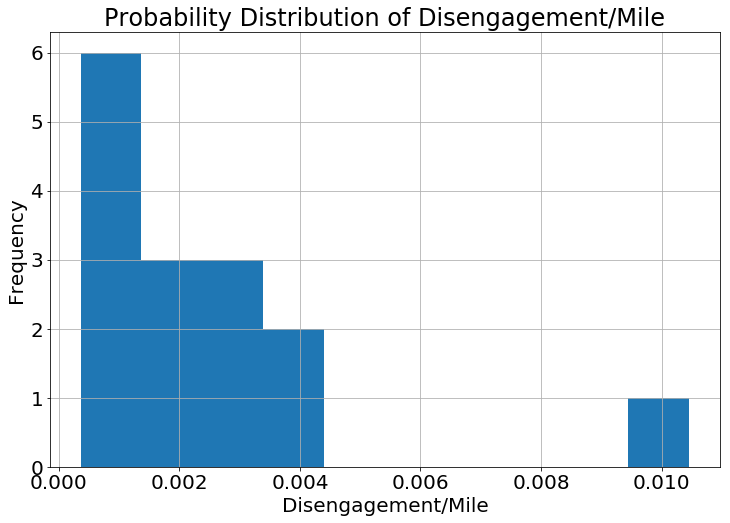

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:1469: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))


Best fitting distribution: expon
Best p value: 0.9806696005068393
Parameters for the best fit: (0.0003605973188528763, 0.0021407886857360853)


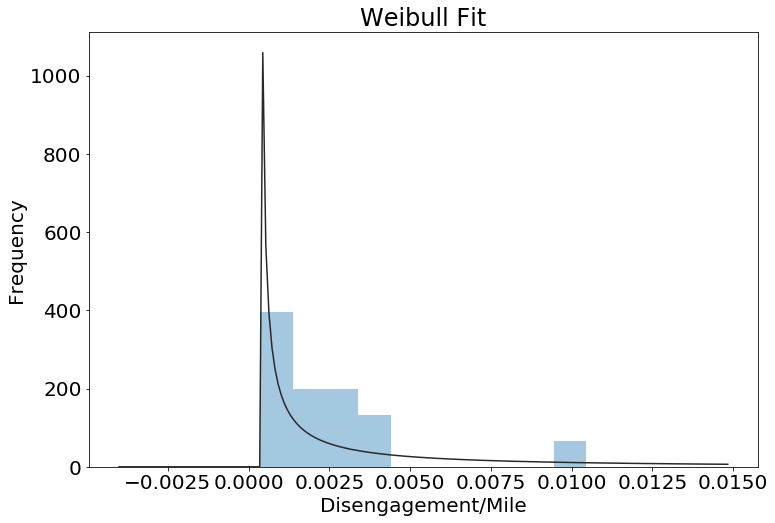

In [17]:

hist = summary_month_df['total disengagements per mile'].dropna().hist(bins = 10)
plt.title('Probability Distribution of Disengagement/Mile')
plt.xlabel('Disengagement/Mile')
plt.ylabel('Frequency')
plt.show()

data_to_fit = summary_month_df['total disengagements per mile'].dropna()
distributions = ['norm','expon','exponweib','weibull_min']
best_distribution, best_p_value, parameters = get_best_distribution(data_to_fit, distributions)

ax = sns.distplot(summary_month_df['total disengagements per mile'].dropna(), kde=False, fit=st.weibull_min, bins=10)
plt.title('Weibull Fit')
plt.xlabel('Disengagement/Mile')
plt.ylabel('Frequency')
plt.show()

Weibull_min distribution fits well. We see that the number of # of
Occurences of Disengagements/mile parameter goes down. 
(parameter k<1: Failure rate decreases over time)


# ----------------------------- Task 2 -----------------------------

### 2.1 Basic Probability

Assumptions in mathematical form:


1. **Random Variable:** X = disengagements per mile $\in$ {0-no_diseng,1-diseng}  <br>
2. **Conditions(C):** Clear - Cl, Cloudy - Cy <br>
   P(C = Cl) = 0.72 & P(C = Cy) = 0.28 <br>
3. AV drives equally well on both types of days


#### 2.1.a.  Random variable for each individual mile follows a **Bernoulli** distribution. A combination of multiple miles follows a **Binomial** distribution.

#### 2.1.b $$ P(X = 1 | C = Cy) = \frac {P(C = Cy | X = 1) * P (X = 1)}{P(C = Cy)} $$

In [18]:
dseng_month_df = dseng_df.groupby(['Month','Weather'], sort = False, as_index = False).count()

#add clear and cloudy day miles in summary df
summary_month_df['clear_day_miles'] = summary_month_df['miles driven in autonomous mode'] * 0.72
summary_month_df['cloudy_day_miles'] = summary_month_df['miles driven in autonomous mode'] * 0.28
summary_month_df.index = summary_month_df['Month']



In [19]:
P_clear = 0.72
P_cloudy = 1-P_clear #  = 0.28

# prob that disengagements occur
P_diseng1 = summary_month_df['total number of disengagements'].sum()/ summary_month_df['miles driven in autonomous mode'].sum() 

# prob that weather = cloudy given diseng, Cause is just a proxy variable for unique rows, it can be one of the other columns as well
P_cloudy_diseng1 = dseng_month_df[dseng_month_df['Weather'] == 'cloudy']['Cause'].sum()/dseng_month_df['Cause'].sum()

# answer
P_diseng1_cloudy = (P_cloudy_diseng1 * P_diseng1)/P_cloudy
print('Probability of disengagement per mile on a cloudy day is {0:.{1}f}'.format(P_diseng1_cloudy,5))


Probability of disengagement per mile on a cloudy day is 0.00590


#### 2.1.c $$ P(X = 1 | C = Cl) = \frac {P(C = Cl | X = 1) * P (X = 1)}{P(C = Cl)} $$

In [20]:
P_clear_diseng1 = dseng_month_df[dseng_month_df['Weather'] == 'clear']['Cause'].sum()/dseng_month_df['Cause'].sum()
P_diseng1_clear = (P_clear_diseng1 * P_diseng1)/P_clear
print('Probability of disengagement per mile on a clear day is {0:.{1}f}'.format(P_diseng1_clear,5))


Probability of disengagement per mile on a clear day is 0.00052


#### 2.1.d In light of above question, we just replace the 'total number of disengagements' column with 'automatic disengagements' column


$$ P(X = auto1 | C = Cy) = \frac {P(C = Cy | X = auto1) * P (X = auto1)}{P(C = Cy)} $$
$$ P(X = auto1 | C = Cl) = \frac {P(C = Cl | X = auto1) * P (X = auto1)}{P(C = Cl)} $$

In [21]:
P_automatic = summary_month_df['number of automatic disengagements'].sum()/ summary_month_df['miles driven in autonomous mode'].sum() 


P_clear_automatic = len(dseng_df[(dseng_df['TypeOfTrigger'] == 'automatic') & (dseng_df['Weather'] == 'clear')])/len(dseng_df[dseng_df['TypeOfTrigger'] == 'automatic'])
P_cloudy_automatic = len(dseng_df[(dseng_df['TypeOfTrigger'] == 'automatic') & (dseng_df['Weather'] == 'cloudy')])/len(dseng_df[dseng_df['TypeOfTrigger'] == 'automatic'])

P_automatic_clear = P_clear_automatic * P_automatic / P_clear
P_automatic_cloudy = P_cloudy_automatic * P_automatic / P_cloudy

print('Probability of automatic disengagement per mile on a clear day is {0:.{1}f}'.format(P_automatic_clear,5))
print('Probability of automatic disengagement per mile on a cloudy day is {0:.{1}f}'.format(P_automatic_cloudy,5))



Probability of automatic disengagement per mile on a clear day is 0.00026
Probability of automatic disengagement per mile on a cloudy day is 0.00281


#### 2.1.e How likely is it that in 12000 miles, there are 150 or more disengagements under cloudy conditions? [Hint: Think of an appropriate approximation that makes the computation feasible/easier.]

this is a binomial disribution, we need to find P(Y>150|cloudy) where Y is the binomial random variable. Y is sum of all individual trials (miles in this case).

Example: Y = 200 indicates that disengagements happened in 200 out of 12000 miles 

$$ P(Y>150|cloudy)  =  \sum_{i = 150}^{12000} {12000\choose150} * P^{i} * (1-P)^{12000-i} $$
where  P = P(X=1|C = Cy) == 0.0059


#reference for approximation: https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/binomial-theorem/normal-approximation-to-the-binomial/
large sample sie (np > 5) so central limit theorem is used 

For the original **Binomial Distribution** summary statistics are: <br>

$\mu$  = n*P = 12000 x 0.0059 = 70.8 <br>
$\sigma^{2} $ = nxPx(1-P) = 70.383 <br>

**Normal Distribution**:
$$ Z = \frac {Y - \mu} {\sigma} $$ 

**Approximate solution**:
$$ P(Y \ge 150) = 1 - P(Y < 150) = 1 - P(Z < \frac{150 - \mu}{\sigma}) $$
$$  = 1 - P(Z < \frac{149.5 - 70.8}{\sqrt{70.383}}) $$ # continuity correction factor
$$  = 1 - P(Z < 9.38) $$

In [22]:
P_Y150_cloudy = 1- st.norm.cdf(9.38)
print("Probabiity that in 12000 miles, there are 150 or more disengagements \
under cloudy conditions is {0}".format(P_Y150_cloudy))
print("The value is very low due to the very low value of probability: P_X_cloudy. It is very unlikely that so many disengagements \
occur")



Probabiity that in 12000 miles, there are 150 or more disengagements under cloudy conditions is 0.0
The value is very low due to the very low value of probability: P_X_cloudy. It is very unlikely that so many disengagements occur


In [23]:
(149.5-70.8)/math.sqrt(70.383)

9.380820917613287

### 2.2 Questions on Hypothesis Testing

#### 2.a Normal Distribution represents the probability distribution of the random variable (under observation) of the sample drawn from a bigger population (assuming null hypothesis is true).

#### 2.b No, we reject the null hypothesis due to lack of evidence under certain significance level ($\alpha $). We conclude that under these conditions alternate hypothesis is statistically probable. In other words, it is likely true. This is not the same as accepting it.

### 2.3 Hypothesis Testing on AV disengagements

We can use hypothesis testing for difference in 2 proportions

n1 = total AV miles ridden * p(cloudy) --> population 1 (cloudy) <br>
n2 = total AV miles ridden * p(clear) --> population 2 (clear)<br>

X1 = total no. of disengagement when cloudy <br>
X2 = total no. of disengagement when clear 

$$\hat{p1} = \frac{X1}{n1}$$ <br>
$$\hat{p2} = \frac{X2}{n2}$$ <br>
$$\hat{p} = \frac{X1 + X2}{n1 + n2}$$ <br>
$$\hat{q} = 1- \hat{p}$$ <br>

Hypothesis testing: <br>

H0 (Null): $$\hat{p1} - \hat{p2} \le 0 $$ <br> i.e. cloudy days have less disengagements than clear days <br> <br>
H1 (Alternate): $$\hat{p1} - \hat{p2} > 0 $$ <br>


Test-Statistic =  $$ Z =  \frac {(\hat{p1} - \hat{p2})- 0} {\sqrt {\hat{p}\hat{q} (\frac{1}{n1}+\frac{1}{n2})} }  $$ <br>

we use the **right tailed test on the normal distribution** 
$$ Z_{dist} \approx N(0,\sqrt {\hat{p}\hat{q} (\frac{1}{n1}+\frac{1}{n2})} )$$


In [24]:
X1 = sum(dseng_df['Weather'] == 'cloudy')
n1 = summary_month_df['miles driven in autonomous mode'].sum()*P_cloudy
p_hat_1 = X1/n1 

X2 = sum(dseng_df['Weather'] == 'clear')
n2 = summary_month_df['miles driven in autonomous mode'].sum()*P_clear
p_hat_2 = X2/n2 

p_hat = (X1+X2)/(n1+n2)
q_hat = 1-p_hat

Z_stat = (p_hat_1-p_hat_2)/math.sqrt(p_hat*q_hat*(1/n1+1/n2))


p_value = 1-st.norm.cdf(Z_stat)
print("Z_stat is {0:0.{1}f}".format(Z_stat,4))
print("p_value is {0} << 0.05. Hence we reject H0, and say that \nIt is statistically likely that number of \
disengagements on a cloudy day are more than a clear day".format(p_value))

Z_stat is 38.1986
p_value is 0.0 << 0.05. Hence we reject H0, and say that 
It is statistically likely that number of disengagements on a cloudy day are more than a clear day


### 2.4 Conditional Probability

In [25]:
# (a)0.6s given that the weather was cloudy
aut_diseng_cloudy = dseng_df[(dseng_df.TypeOfTrigger == 'automatic') & (dseng_df.Weather == 'cloudy')]

p_06s_auto_cloudy = sum(aut_diseng_cloudy.ReactionTime > 0.6)/aut_diseng_cloudy.shape[0]

print(" P(>0.6s given that the weather was cloudy) = {0}".format(p_06s_auto_cloudy))


# (a)0.9s given that the weather was clear
aut_diseng_clear = dseng_df[(dseng_df.TypeOfTrigger == 'automatic') & (dseng_df.Weather == 'clear')]

p_09s_auto_clear = sum(aut_diseng_clear.ReactionTime > 0.9)/aut_diseng_clear.shape[0]

print(" P(>0.9s given that the weather was clear) = {0}".format(p_09s_auto_clear))

 P(>0.6s given that the weather was cloudy) = 0.473551637279597
 P(>0.9s given that the weather was clear) = 0.28125


### 2.5 Theorem of total probability: Automatic AV disengagement

ex:$p(accident) = p(t>0.6s|autoDiseng,cloudy)* p(autoDiseng | cloudy)* p(cloudy) + p(t>0.9s|autoDiseng,clear)* p(autoDiseng | clear)* p(clear)  $

In [26]:
accident_prob = p_06s_auto_cloudy* P_automatic_cloudy*P_cloudy + p_09s_auto_clear* P_automatic_clear *P_clear
print("Probability of accident per mile is conditional sum of two probs in section 2.4 = {0}". format(accident_prob))

Probability of accident per mile is conditional sum of two probs in section 2.4 = 0.0004255496022595694


### 2.6 Comparison with human drivers

We see that p(accident by AV) in $4.25*10^{-4}$ is much higher than p(accident by human) = $2*10^{-6}$ . So it is not ready for market yet in this case.

# ----------------------------- Task 3 -----------------------------

# Question 1

In [34]:
#Adding a column names "Class" 
dict_names={'Incorrect behavior prediction of others':'Controller','Recklessly behaving agent':'Controller',\
           'Unwanted Driver Discomfort':'Controller','Adverse road surface conditions':'Perception System',\
           'Emergency Vehicle':'Perception System','Position Estimation Failure':'Perception System',\
           'Incorrect Traffic Light Detection':'Perception System','System Tuning and Calibration':'Computer System',\
           'Hardware Fault':'Computer System','Software Froze':'Computer System'}

dseng_df['Class']=dseng_df['Cause'].map(dict_names)

,Month,Car,Location,Weather,TypeOfTrigger,ReactionTime,Cause,Month_actual,Class
0,14-Sep,WDD2221851A001072,urban-street,cloudy,automatic,0.58,Incorrect Traffic Light Detection,Sep,Perception System
1,14-Sep,WDD2221851A001072,urban-street,cloudy,automatic,0.66,Adverse road surface conditions,Sep,Perception System
2,14-Sep,WDD2221851A001072,urban-street,cloudy,automatic,1.93,Position Estimation Failure,Sep,Perception System
3,14-Sep,WDD2221851A001072,urban-street,cloudy,automatic,0.65,Emergency Vehicle,Sep,Perception System
4,14-Sep,WDD2221851A001072,urban-street,cloudy,automatic,0.64,Adverse road surface conditions,Sep,Perception System


# Questions 2,3,4,5

In [110]:
accuracy=[None]*5
for itr in range(5):    # Do this 5 times
    #Split data frame into 80:20 ratio for training:testing
    y=dseng_df.Class
    x=dseng_df.drop(['Class','Month','Car','ReactionTime','Cause'],axis=1)  
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    train=x_train.join(y_train)  
    test=x_test.join(y_test)  
    test.reset_index() # Reset index  
    class_names= ['Controller','Computer System','Perception System'] 

    #Priors
    total=y_train.value_counts().sum()  
    p1=y_train.value_counts()['Controller']/total  
    p2=y_train.value_counts()['Computer System']/total  
    p3=y_train.value_counts()['Perception System']/total  
    priors={'Controller':p1,'Computer System':p2,'Perception System':p3}

    #Conditional probability
    #P(Feature=feature|C=C,CS,PS)

    cond_prob1=train.groupby(['Class','Location'])['Weather'].count()/train.groupby(['Class'])['Weather'].count()
    cond_prob2=train.groupby(['Class','Weather'])['Location'].count()/train.groupby(['Class'])['Location'].count()    
    cond_prob3=train.groupby(['Class','TypeOfTrigger'])['Location'].count()/train.groupby(['Class'])['Location'].count()

    dict_CPT={'prob1':cond_prob1,'prob2':cond_prob2,'prob3':cond_prob3}
    dict_feature={'prob1':'Location','prob2':'Weather','prob3':'TypeOfTrigger'}

    for Key in ['prob1','prob2','prob3']:
        my_cond_prob=dict_CPT[Key]               #Select a CPT to work with
        for Class in class_names:                #Access all class names
            x = dict_feature[Key]                #Determine what feature we need to work with in this particular CPT
            for value in dseng_df[x].unique():    #get different values of that particular feature in the data set
                try:    
                    _=my_cond_prob.loc[Class,value]

                except:
                    my_cond_prob.loc[Class,value]=0
                 
    print("CPT Table is as follows: \n")
    print(cond_prob1,'\n\n', cond_prob2,'\n\n',cond_prob3,'\n\n')    

    prob_class=[]  
    answer=[]                                   # Final Naive Bayes Prediction for test cases 

    for x in range(len(test)):  
        z=test.iloc[x]
        for Class in class_names:  
            prob_class.extend([cond_prob1.loc[Class,z[0]]*cond_prob2.loc[Class,z[1]]*cond_prob3.loc[Class,z[2]]*priors[Class]])  

        highest=max(prob_class) 
        for x in range(3):  
            if prob_class[x]==highest:  
                answer.append(class_names[x]) 
        prob_class=[] 


    ctr=0  
    for i in range (len(test)):  
        if answer[i]!=y_test.iloc[i]:  
            ctr+=1  

    correct=len(y_test)-ctr
    accuracy[itr]=correct/len(y_test)*100  
    print('Accuracy for iteration: {0} is: {1} \n \n'.format(itr+1, round(accuracy[itr],4)))

from statistics import mean
print("Average Accuracy is: {0} percent".format(mean(accuracy)))

CPT Table is as follows: 

Class              Location    
Computer System    highway         0.054393
                   urban-street    0.945607
Controller         urban-street    1.000000
Perception System  urban-street    1.000000
Controller         highway         0.000000
Perception System  highway         0.000000
Name: Weather, dtype: float64 

 Class              Weather
Computer System    clear      0.627615
                   cloudy     0.372385
Controller         clear      0.003425
                   cloudy     0.996575
Perception System  cloudy     1.000000
                   clear      0.000000
Name: Location, dtype: float64 

 Class              TypeOfTrigger
Computer System    automatic        0.497908
                   manual           0.502092
Controller         automatic        0.123288
                   manual           0.876712
Perception System  automatic        0.829861
                   manual           0.170139
Name: Location, dtype: float64 


Accuracy for

# Question 6

### Average accuracy is around 80 percent, so it classifies roughly 80 percent data correctly
### If we were to leave to chance, the number of correct classifications we could have obtained would be Expectation value, which is 33.3%, the naive bayes definitely performs better than simple guessing

